总览

这个端到端的演练使用tf.estimatorAPI 训练了逻辑回归模型。该模型通常用作其他更复杂算法的基准。

In [ ]:
# !pip install -q sklearn

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

加载泰坦尼克号数据集

给定诸如性别，年龄，阶级等特征，您将使用泰坦尼克号数据集（具有较高的发病率）目标来预测乘客的生存。

In [2]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

探索数据

数据集包含以下功能

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


训练和评估集中分别有627个和264个示例。

In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

大部分乘客都在20多岁和30多岁之间。

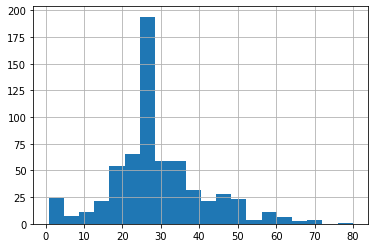

In [7]:
dftrain.age.hist(bins=20)

男性乘客人数大约是女性乘客人数的两倍。

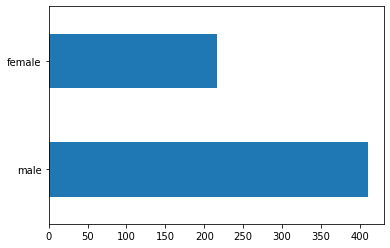

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

大多数乘客属于“三等”舱。

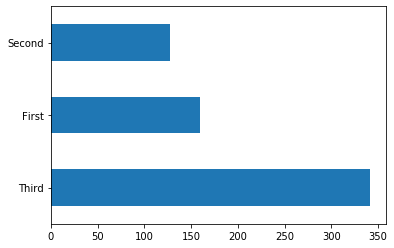

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

与男性相比，女性的生存机会要高得多。这显然是模型的预测功能。

Text(0.5, 0, '% survive')

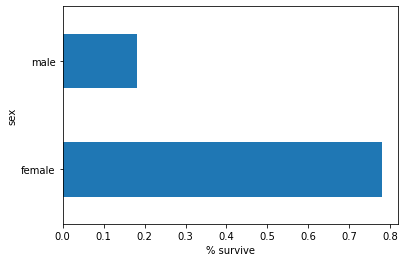

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

模型的特征工程

估算器使用一个称为要素列的系统来描述模型应如何解释每个原始输入要素。估计器需要一个数字输入向量，特征列描述模型应如何转换每个特征。

选择和制作正确的特征列集是学习有效模型的关键。特征列可以是原始特征中的原始输入之一dict（基础特征列），也可以是使用在一个或多个基础列上定义的转换创建的任何新列（派生特征列）。

线性估计器同时使用数字和分类特征。特征列可与所有TensorFlow估计器一起使用，其目的是定义用于建模的特征。此外，它们还提供了一些功能工程功能，例如单热编码，规范化和存储桶化。

基本要素列

In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

用于input_function指定如何将数据转换为tf.data.Dataset以流方式馈入输入管道的。tf.data.Dataset接受多种来源，例如数据框，CSV格式的文件等。

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

您可以检查数据集：

In [13]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'Third' b'First' b'Third' b'Third' b'Third' b'First' b'First'
 b'Second' b'Third']

A batch of Labels: [0 1 0 0 0 1 1 1 0 0]


您还可以使用tf.keras.layers.DenseFeatures图层检查特定要素列的结果：

In [14]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[40.],
       [28.],
       [28.],
       [28.],
       [38.],
       [29.],
       [35.],
       [26.],
       [36.],
       [22.]], dtype=float32)

DenseFeatures 仅接受密集张量，要检查分类列，您需要先将其转换为指标列：

In [15]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

在将所有基本特征添加到模型后，让我们训练模型。使用tf.estimatorAPI 训练模型只是一个命令：

In [16]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7689394, 'accuracy_baseline': 0.625, 'auc': 0.8313437, 'auc_precision_recall': 0.78852046, 'average_loss': 0.5064287, 'label/mean': 0.375, 'loss': 0.49798286, 'precision': 0.74358976, 'prediction/mean': 0.2949373, 'recall': 0.5858586, 'global_step': 200}


派生特征列

现在您达到了75％的准确性。单独使用每个基本功能列可能不足以解释数据。例如，性别和标签之间的相关性对于不同的性别可能是不同的。因此，如果只为gender="Male"和学习单个模型权重gender="Female"，则不会捕获每个年龄性别组合（例如，区分gender="Male"AND age="30"AND gender="Male"AND age="40"）。

要了解不同要素组合之间的区别，可以将交叉要素列添加到模型中（也可以在交叉列之前对年龄列进行分类）：

In [17]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

将组合功能添加到模型后，让我们再次训练模型：

In [18]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.84037346, 'auc_precision_recall': 0.7668463, 'average_loss': 0.48198462, 'label/mean': 0.375, 'loss': 0.47494903, 'precision': 0.6636364, 'prediction/mean': 0.40991464, 'recall': 0.7373737, 'global_step': 200}


现在，它达到了77.6％的准确度，比只接受基本功能训练的准确度要好一些。您可以尝试使用更多功能和转换，看看是否可以做得更好！

现在，您可以使用火车模型从评估集中对乘客进行预测。优化TensorFlow模型以一次对一批或一组示例进行预测。之前，eval_input_fn使用整个评估集定义了。

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\30660\AppData\Local\Temp\tmpq52uzr_3\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


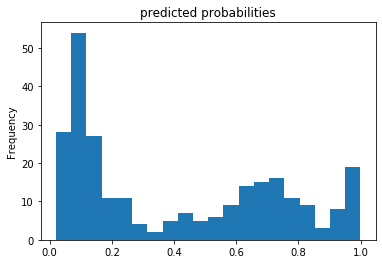

In [19]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

最后，查看结果的接收器工作特性（ROC），这将使我们更好地了解真阳性率和假阳性率之间的折衷。

(0, 1.05)

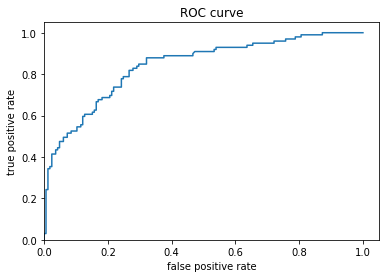

In [20]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)